# Physics-Informed Neural Network for the Diffusion Equation
  Ryan Schanta \
  CIEG 678 \
  18 May 2024 
  
  
  
  ## Background
  ### Definition of a PINN
  ***Physics-Informed Neural Networks (PINNS)*** as introducted by Karniadakis et al [[1]](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125) are a broad category of neural networks that can be used to solve a wide variety of ordinary and partial differential equations. PINNs supplement any differentiable neural network architecture by enforcing loss conditions in the optimization algorithm corresponding to the physical governing equation. For example, we know that any solution of a PDE needs to respect its initial conditions and boundary conditions. Additionally, any solution output by the neural network of course has to satisfy the underlying governing equation. These conditions can be added to a more traditional loss term (such as RMSE from data) to construct a loss function with a *physical basis*. For PDEs, a PINN loss function $\mathcal{L}$ often has the following form:
  
  $$\mathcal{L} =  \lambda_1\mathcal{L}_{PDE} + \lambda_2\mathcal{L}_{IC} + \lambda_3\mathcal{L}_{BC} +  \lambda_4\mathcal{L}_{Data}$$
  
  where the total loss is constructued from the weighted summation of individual loss functions. The $\lambda$ terms represent ***weights*** in the loss function, corresponding to the relevant important of each individual loss function. For example, placing a higher weight on $\lambda_2$ would cause the loss function to consider the initial conditions more, likely leading to a model that is better at getting the initial conditions correct, potentially at the expense of getting other conditions wrong. PINNs are known to be sensitive to weight functions, and domain knowledge and hyperparameter tuning is crucial to build an optimal architecture.
  
  ### The 1D Diffusion Equation
  In this notebook, we will consider the example of the diffusion equation in an infinitely long pipe and attempt to find its solution via a PINN. This problem is a 1-dimensional diffusion problem in $x$ governed by:
  $$\frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$
  
  where $c$ is a concentration and $D$ is a diffusion coefficient corresponding to the strength of the process. Visually, the model domain can be conceptualized as:
  
  ![model_domain](./Figures/model_domain.JPG)
  
  This could correspond to an environmental flow such as a river, where we are interested in tracking the spread of some pollutant from a collection of sources. Note, we can easily specify some initial condition by some function in $x$ that we will call $\alpha(x)$. However, the boundary condition is more subtle. Since the pipe is infinitely long, the boundary condition is simply that *the concentration c approaches 0 at $x=\pm \infty$*. We expect the contaminant to diffuse out over the spatial domain. If the process were to go on forever, the contaminant would reach $\pm \infty$. We can thus express the IC and BC as:
  
  $$c(x,0) = \alpha(x)$$
  
  $$c(\pm \infty,t) = 0$$
  
 Analytically, this PDE has the known analytic solution for $\alpha(x)$ over the model domain, with the form:
  $$c(x,t) = \int_{-\infty}^{\infty} \frac{\alpha{(\xi)}}{\sqrt{4\pi Dt}}\exp{\left(\frac{-(x-\xi)^2}{4Dt}\right)}$$
  
  We can use this analytical solution to visualize the correctness of our solutions.
  
  ### Basic PINN architecture
  Now that the problem is formed, it is instructive to consider the big-picture view of what we want the PINN to look like and do. The diffusion equation is the governing equation for a dependent variable $c$ under two independent variables $x$ and $t$. The goal is thus to construct a model $\mathcal{M}$ that maps two *scalar* inputs to one *scalar* output:
  
  $$c = \mathcal{M}(x,t)$$
  
  This seems trivial, but is worth emphasizing. The form of the neural network is often inspired by the dimensionality of the inputs and outputs. Broadly speaking, a neural network may take *vectors* or *tensors* as inputs or outputs. This problem could have just as well been formulated in the form $\vec{c} = \mathcal{M}(\vec{x},t)$ where $\vec{x}$ is a *vector* corresponding to the entire problem domain, and $\vec{c}$ is the concentration across the entire domain at some time $t$. We could also develop a model $\mathbf{c} = \mathcal{M}(\vec{x},\vec{t})$ where $\mathbf{c}$ is a *tensor* of the concentration $c$ across the entire domain in space specified by the vector $\vec{x}$ and the entire domain in space specified by the vector $\vec{t}$. There are advantages and disadvantages to all of these approaches, but we will stick with the scalar model for simplicity. This scalar formulation is also popular in the literature. Vectorizing $\vec{x}$ does, however, lend itself naturally to convolution. 
  
  Thus, now that we have established what the inputs and outputs are, we can visualize the neural network's overall architecture. We have 2 input nodes $x$ and $t$ as expected, feeding through some arbitrary neural network to an output $c$
  
  ![model_domain](./Figures/nn_diagram.JPG)
  
  Up to this point, this is just a generic neural network. What makes it a PINN is what comes after the neural network outputs is parameters, since this is where we evaluate the loss function. The first step is automatic differentiation.
  ### Automatic Differentiation
  ***Automatic Differentiation*** is the mechanism by which derivatives of the output functions can be taken. Automatic differentiation differs from finite different methods that are common in numerical computing- it is much more efficient. There are a few different schemes for automatic differentiation (backwards and forwards methods). They all broadly rely on the chain rule. Automatic differentiation is a crucial algorithm frequently used in ML for tasks such as *back-propagation* as well.
  
  To consider how automatic differentiation works, we need to first understand how a computer calculates functions. Any series of operations can be represented as a *tree*, and a computer effectively works through this tree when it calculates some value. For example, below is the structure for some function $f(x,y)=[x+\sin{(y)}][y+3]$
  
  ![autodiff](./Figures/autodiff.JPG)
  
  We see that the task of calculating this function is broken into several steps until $f$ is output. Each of these steps can be thought of as an individual function. So calculating $f$ is really a composition of several functions. As such, we can calculate the derivative of $f$ by working our way down the tree via the chain rule, noting to use the multivariable chain rule when applicable:
  
  $$\frac{df}{dx} = \frac{df}{db}\frac{db}{dx} = (c)(1) = c $$
  
  
 $$\frac{df}{dy} = \frac{df}{db}\frac{db}{dg}\frac{dg}{dy} + \frac{df}{dc}\frac{dc}{dy} = (c)(1)(\cos{(y)}) + (b)(1) = c\cos{(y)} + b $$ 
 
 This is of course a very formulaic process that is efficiently done via many pre-packaged algorithms. Examining our neural network, we see that it too is a tree to output $c$ (just sideways!), so we can claculate derivatives with respect to its inputs, provided we know the derivative of everything in between. This differs from finite differences, for example, which are purely numeric in nature. In autodifferentiation, we can exploit the differentiability of the activation functions. This is also how we can update weights in algorithms such as back-propagation. This is implemented in the loss function code section.
 
 ### Calculating the Loss Term
 With the output $c$ calculated, we can calculate its derivatives as we need to satisfy our PDE. Recall the governing PDE is:
 
  $$\frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$
  
  So we can define a loss term as:
  
$$\mathcal{L}_{PDE} = \left|\frac{\partial c}{\partial t} - D \frac{\partial^2 c}{\partial x^2}\right|$$

The RHS of this should be 0 for any $c$ at time $x$ and $t$, and if it is not, this corresponds to error, which we want to minimize.

The initial condition loss term can also be defined. Note, that since we have a scalar neural network, this only needs to be satisfied for values where $t=0$. We will deal with this later when constructing the neural network.

$$\mathcal{L}_{IC} = \left|c(x,0) - \alpha(x)\right|$$

We could also specify a boundary condition, but since they are at infinity and we are on a finite grid that will be relatively small, I choose not to. However, any desired boundary condition loss term could be constructed in a similar way. 

Note that I also do not have a data loss term. The significance of this is that I am effectively not training on any data- the idea is essentially to randomly start by guessing random solutions, and let the optimization algorithms update the weights of the neural network to "learn" the underlying PDE.

So the final loss term is:

$$\mathcal{L} = \mathcal{L}_{PDE} + \lambda \mathcal{L}_{IC} $$

where I use $\lambda$ as weight factor. This is effectively a *hyperparameter*.

### Is the problem well-posed? How could we make it better?
This solution mechanism presents an interesting possibility of PINNs. In the loss term, I did not specify any boundary conditions. We are effectively solving a PDE without a boundary condition. In classic PDE theory, we really need to specify a BC. There is nothing inherent to the boundary values in this formulation, yet we are still able to proceed. Of course, the PINN solution ends up not being very close to the analytical solution, and this is potentially why. However, boundary conditions are not the only "physically-informed" conditions we have- we also know that mass must be conserved (an integral quantity) and that the concentration can never be negative. Although not implemented here, these could be enforced in the loss term.

# Code: Formulation and Architecture
## Inputs: The `p` Dictionary
The code below is implemented through a series of functions that encapsulate different parts of the ML workflow piece by piece. It is worth noting, that the main function used to define and train the neural network is `Diffusion_Gaussian`, which takes in a dictionary `p` that defines all the key parameters and hyperparameters. It has the following form:
```
p = {
     ## NAME OF RUN
         "name": 'D1_L1_At_ICt',
         
     ## TIME INFORMATION
        "t_0": 0,
        "t_f": 20,
        "nt": 1000,
    
    ## DIFFUSION COEFFICIENT
        "D": 1,
        
     ## SPATIAL INFORMATION
        "x_l": -10,
        "x_r": 10,
        "nx": 1000,
        
    ## ML INFORMATION
        "epochs": 250,
        "lmb": 1,
        "nodes": 64,
        "layers": 4,
        "act": 'tanh'
}
```
- **Time Information**: the neural network will work on a temporal domain from time $t0$ to time $tf$ at $n=nt$ grid points in time.
- **Diffusion Coefficient**: the value of $D$ in the diffusion equation, corresponding to the strength of the diffusive process.
- **Spatial Information**: the neural network will work on a spatial domain from some left end point $x_l$ to some right endpoint $x_r$ at $n=nx$ grid points in space.
- **ML Information**: the ML hyperparameters. The network constructed is just a series of fully connected layers. The number of layers can be specified by `layers` and the number of nodes in each layer can be specified by `nodes`. The activation number can be specified by `act`, and this should be a valid activation function in Keras. `epochs` sets the number of epochs for training, and `lmb` the value of $\lambda$ as developed in the loss term

## `Diffusian_Gaussian`
Running the `Diffusion_Gaussian` function for the Dictionary `p` runs the following proceses, which are stepped through in detail:
- Sets up the domain of the problem over a grid in $x$ and $t$ and ensures valid tensorflow formatting
- Makes a fully connected neural network with the layers, number of nodes, and activation function specified using the *Adam* optimizer, displaying the model summary.
- Loops through for the number of epochs specified, iteratively updating model weights based on the loss function and gradient descent.
- Outputs the final predicted values for all $x$ and $t$ values in the domain
- Outputs a summary of parameters to a text file, outputs the results as an apache Parquet and a MATLAB structure, and plots the training loss records over Epochs.

# Code: Step by Step Walkthrough
## Setup: Libraries
The following libraries first need to be imported. Note, the *TensorFlow* library is used to construct the elements of the machine learning network, and that the output file format is the *Apache Parquet*

In [1]:
#%% Library Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import scipy.io as sio
import os

## Defining the Neural Network
Here, the neural network is constructed as a series of `p['layers']` fully connected layers with `p['nodes']` nodes each, with an activation function specified by `p['act']`. **Adam** is used as the optimizer algorithm, although this can be changed if desired. The function returns both the optimizer (Adam) and tensorflow model object for use.

In [2]:
def make_NN(p):
    "Makes a Neural Network with the parameters specified in p"
    
    ## Initialize network
    model = tf.keras.models.Sequential() # Keras Sequential Network
    model.add(tf.keras.layers.Input((2,))) # 2 inputs: t and x
    

    ## Add in specified layers
    for _ in range(p['layers']):
        model.add(tf.keras.layers.Dense(units=p['nodes'], activation=p['act']))
    model.add(tf.keras.layers.Dense(units=1))
    
    model.summary() # print summary
    
    # Set optimizer to Adam
    optm = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    return optm, model

## Creating the Spatial Domain
The following functions are used to create the spatial domain for the problem. There are two dimensions $t$ and $x$. The following functions work in sequence as described:
- `make_domain`: Creates 2 arrays, `td` and `xd` corresponding to the temporal and spatial extent of the problem

- `prep_x_t`: Alters the output of `make_domain` to valid Tensorflow tensors, ensuring the correct dimensionality for each

- `tensorize_inputs`: The ML model expects a 2 column matrix of the form [t x] for different points, so the outputs of `prep_x_t` are concatenated to accomodate this.

In [3]:
def make_domain(p):
    "Set up problem domain using variables specified in p"
    td = np.linspace(p['t_0'], p['t_f'], p['nt']).reshape(-1, 1)
    xd = np.linspace(p['x_l'], p['x_r'], p['nx']).reshape(-1, 1)
    return td, xd


def prep_x_t(t,x):
    "Ensure correct dimensionality and type for Keras Model"
    t = t.reshape(-1,1)
    t_ = tf.constant(t, dtype = tf.float32)
    x = x.reshape(-1,1)
    x_ = tf.constant(x, dtype = tf.float32)
    return t_, x_

def tensorize_inputs(t_, x_):
    "Get into a valid tensorflow tensor for a NN"
    tf_in = tf.concat([t_, x_], axis=1)
    return tf_in

def prepare_mesh(td, xd):
    "Get all permutations of time and spatial positions"
    
    # Meshgrid of Variables
    tt, xx = np.meshgrid(td.flatten(), xd.flatten())
    # Tiles the meshgrid to get all combinations
    combined_array = np.column_stack((tt.flatten(), xx.flatten()))
    # Makes into valid tensorflow tensor
    combined_tensor = tf.constant(combined_array, dtype=tf.float32)
    return combined_tensor

## Sampling the spatial domain
Now that the spatial domain has been defined, we need to sample points from it to use as our input points. This is effectively preparing a mesh or collocation points. I choose to sample every point in the domain to get full coverage to get the mesh. If one wanted to constrain/limit their collocation points, random sampling could be employed as well. The `prepare_mesh()` function returns a long, skinny nx2 tensorflow tensor of all possible permutations of time and space points.

In [4]:
def prepare_mesh(td, xd):
    "Get all permutations of time and spatial positions"
    
    # Meshgrid of Variables
    tt, xx = np.meshgrid(td.flatten(), xd.flatten())
    # Tiles the meshgrid to get all combinations
    combined_array = np.column_stack((tt.flatten(), xx.flatten()))
    # Makes into valid tensorflow tensor
    combined_tensor = tf.constant(combined_array, dtype=tf.float32)
    return combined_tensor

## Outputing Results
The following functions are just helper functions to output the results of the fit as a parquet, output the values in p to a textfile, plot the loss record and save the file, and save a MATLAB structure. These are all named with the `name` specified in `p`. The details of this are not crucial to the formulation.

In [5]:
def output_results(combined_tensor,u_results,name):
    "Output results to a nice parquet file"
    res = np.concatenate((combined_tensor, u_results), axis=1)
    df = pd.DataFrame(res, columns=['t', 'x', 'u'])
    table = pa.Table.from_pandas(df)
    pq.write_table(table, f"./{name}/{name}.parquet")
    return 

def print_values(p):
    "Print values of p to a log file for record keeping"
    
    name = p['name']
    if not os.path.exists(f'./{name}'):
        os.makedirs(f'./{name}')
        
    with open(f'./{name}/{name}_log.txt', 'w') as file:
        for key, value in p.items():
            file.write(f"{key} is: {value}\n")

def plot_ML_record(train_loss_record,p):
    "Plot the ML training record of loss over time"
    plt.figure(figsize = (10,8))
    plt.plot(train_loss_record)
    plt.title("Training Record")
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")
    name = p['name']
    plt.savefig(f'./{name}/{name}_train.png')
    plt.show()
    return

def save_p_in_MATLAB(p):
    matlab_struct = {}
    for key, value in p.items():
        matlab_struct[key] = value
        
    name = p['name']
    # Save the MATLAB structure to a .mat file
    sio.savemat(f'./{name}/{name}_p.mat', {'p': matlab_struct})
    return

## Defining the Initial Condition
Here, we define the initial condition for $c$, given as $\alpha{(\xi)}$ above. We also output an array of 0's of the same dimension, corresponding to $t=0$ for each point. Here, we let:

$$\alpha(\xi) = 3e^{-x^2}$$

In [6]:
def IC_function_GAUSS(x):
    "Initial Condition to enforce on x"
    
    # IC Equation
    u_IC = 3.0 * tf.exp(-tf.square(x))
    
    # Array of zeros with same dimensions as u_IC
    t_IC = tf.zeros_like(u_IC)
    
    return t_IC,u_IC


## Defining the Loss Function
This is the key to the whole PINN formation. It is also a bit more technical that most simple neural networks in Keras, since most of the time we use a simpler loss function. This is where we use automatic differentiation. **GradientTape** is TensorFlow mechanism for automatic differentiation. We declare a "tape" for order of derivative we want to track using a `with` statement, and keeping `persistent=True` to ensure we can reuse the tape. As a consequence, we need two GradientTapes to calculate a second derivative, but only one for the first derivative, and they must be nested appropriately.

After declaring the tapes, we start by inputting all our grid points to the neural network, which has been randomly initiatialized with some weights. Then we calculate the derivatives we need, and plug them back into the governing PDE to calculate the PDE loss. We repeat the process for the initial condition, putting in all the grid points at the initial time, and compare the results to the IC we defined above to calculate the loss. The losses are then combined using the provided $\lambda$ in `p`.

In [7]:
def pde_loss_GAUSS(t,x,net,p):
    
    # Enforce correct shape and types for tensors
    t_, x_ = prep_x_t(t,x)
    
    # Enforce initial conditions
    t_IC,u_IC = IC_function_GAUSS(x_)
    
    
    # Set up gradient tape for derivatives- Need 2 since 2nd derivative
    with tf.GradientTape(persistent=True) as tape_2:
        with tf.GradientTape(persistent=True) as tape_1:
            tape_1.watch(t_)
            tape_1.watch(x_)
            tape_2.watch(t_)
            tape_2.watch(x_)
            
            # Prepare inputs to Neural Network
            in_u = tensorize_inputs(t_, x_)
            # Pass Through Neural Network
            u = net(in_u)
    
            # Calculate 1st derivatives
            du_dx = tape_1.gradient(u, x_)
            du_dt = tape_1.gradient(u, t_)
            
            # Calculate 2nd derivative  
            d2u_dx2 = tape_2.gradient(du_dx, x_)
        
    # PDE Loss Term
    D = p['D']
    pde_loss = du_dt - D*d2u_dx2
    
    # Initial Condition Loss Term
    in_u0 = tensorize_inputs(t_IC, x_)
    IC_loss = net(in_u0) - u_IC
    
    # Sum up Loss, Use Provided Weight
    lmb = p['lmb']
    square_loss = tf.square(pde_loss) + lmb*tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

## `Diffusion_Gaussian` function definition
Finally, all the pieces needed for the `Diffusion_Gaussian` function are defined, and we can construct the function

In [8]:
def Diffusion_Gaussian(p):
    # Make Problem domain
    td, xd = make_domain(p)
    
    # Make Neural Network
    optm, NN = make_NN(p)
    
    # Initialize Loss Record
    train_loss_record = []
    
    # Loop through each number of epochs to train model
    for itr in range(p['epochs']):
        # Set up gradient tape for ADAM optimization
        with tf.GradientTape() as tape:
            train_loss = pde_loss_GAUSS(td,xd,NN,p)
            train_loss_record.append(train_loss)
    
            grad_w = tape.gradient(train_loss, NN.trainable_variables)
            optm.apply_gradients(zip(grad_w, NN.trainable_variables))
        print(f"Current Iteration is: {itr}")
        if itr % 1000 == 0:
            print(train_loss.numpy())
            
    # Apply model
    combined_tensor = prepare_mesh(td, xd)
    pred_u = NN.predict(combined_tensor)
    
    # Save Results
    print_values(p)
    output_results(combined_tensor,pred_u,p['name'])
    save_p_in_MATLAB(p)
    plot_ML_record(train_loss_record,p)
    
    # Display Success
    print("Successfully trained network and output results!")
    return

## Running the Code
Now we run the `Diffusion_Gaussian(p)` function to create and train our network under the given values in `p`.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12737 (49.75 KB)
Trainable params: 12737 (49.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Current Iteration is

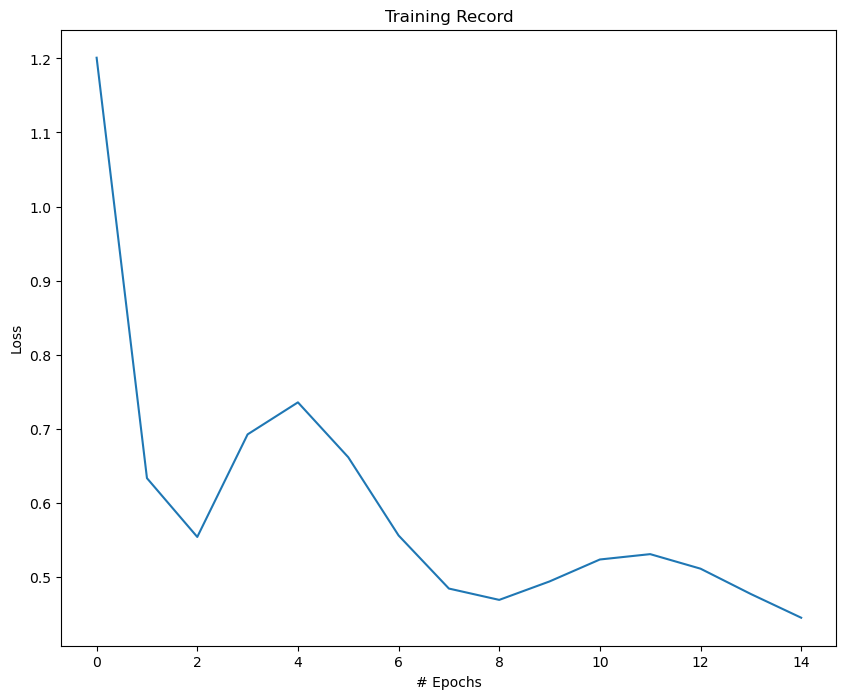

Successfully trained network and output results!


In [9]:
p = {
     ## NAME OF RUN
         "name": 'Sample_PINN',
         
     ## TIME INFORMATION
        "t_0": 0,
        "t_f": 20,
        "nt": 1000,
    
    ## DIFFUSION COEFFICIENT
        "D": 1,
        
     ## SPATIAL INFORMATION
        "x_l": -10,
        "x_r": 10,
        "nx": 1000,
        
    ## ML INFORMATION
        "epochs": 15,
        "lmb": 1,
        "nodes": 64,
        "layers": 4,
        "act": 'tanh'
}

Diffusion_Gaussian(p)

## Things to Try
There are many parameters that can be changed in `p`, each with notable impacts on the solution. Some questions to consider:
- How many epochs do you need for convergence?
- How does the choice of temporal/spatial domain make a difference?
- How does the strength of diffusion $D$ come into play?
- How does the depth and number of nodes in the neural network affect performance?
- How does the choice of activation function affect performance (perhaps try `ReLU`)
- How does the weighting factor affect the results?
- How would a different initial condition fare?